In [29]:
import lightkurve as lk
import pandas as pd
import numpy as np
import xgboost as xgb
import missingno as msno
import random
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score


%matplotlib inline

In [2]:
search_result = lk.search_targetpixelfile('Pi Mensae', mission='TESS', sector=1)
search_result

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


SearchResult containing 1 data products.

target_name                     productFilename                        description     distance
----------- ------------------------------------------------------- ------------------ --------
  261136679 tess2018206045859-s0001-0000000261136679-0120-s_tp.fits Target pixel files      0.0

In [3]:
tpf = search_result.download(quality_bitmask='default')
tpf

TessTargetPixelFile(TICID: 261136679)

In [30]:
tpf.mission

'TESS'

In [5]:
tpf.targetid  # TESS Input Catalog (TIC) Identifier

261136679

In [6]:
tpf.sector  # TESS Observation Sector

1

In [7]:
tpf.camera  # TESS Camera Number

4

In [8]:
tpf.ccd  # TESS CCD Number

2

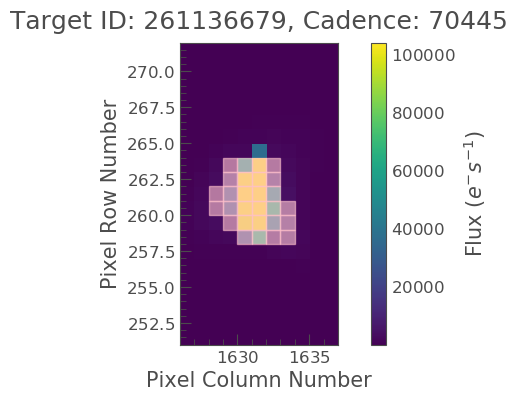

In [9]:
tpf.plot(aperture_mask=tpf.pipeline_mask);

In [10]:
lc = tpf.to_lightcurve()

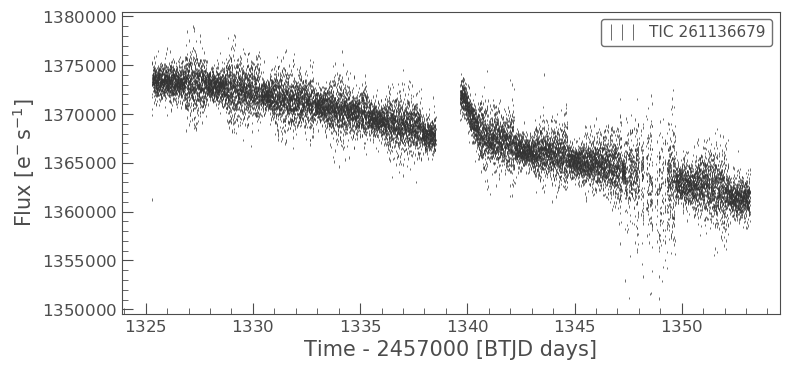

In [11]:
lc.errorbar()

In [12]:
lc.flux

array([1361239.1, 1369874.9, 1370507.1, ..., 1359964.8, 1364312.1,
       1359780.8], dtype=float32)

In [13]:
lc.time

array([1325.29698328, 1325.29837215, 1325.29976102, ..., 1353.17431099,
       1353.17569985, 1353.17708871])

In [14]:
lc.astropy_time.utc.iso

array(['2018-07-25 19:06:30.172', '2018-07-25 19:08:30.171',
       '2018-07-25 19:10:30.169', ..., '2018-08-22 16:09:51.287',
       '2018-08-22 16:11:51.284', '2018-08-22 16:13:51.281'], dtype='<U23')

In [32]:
df = pd.DataFrame(zip(lc.astropy_time.utc.iso, lc.time, lc.flux), columns=['iso_time','time', 'flux'])

In [33]:
df['iso_time']=pd.to_datetime(df.iso_time)

In [36]:
df['hour'] = df.iso_time.dt.hour
df['day'] = df.iso_time.dt.day
df['month'] = df.iso_time.dt.month
df['year'] = df.iso_time.dt.year
df['y'] = df.flux

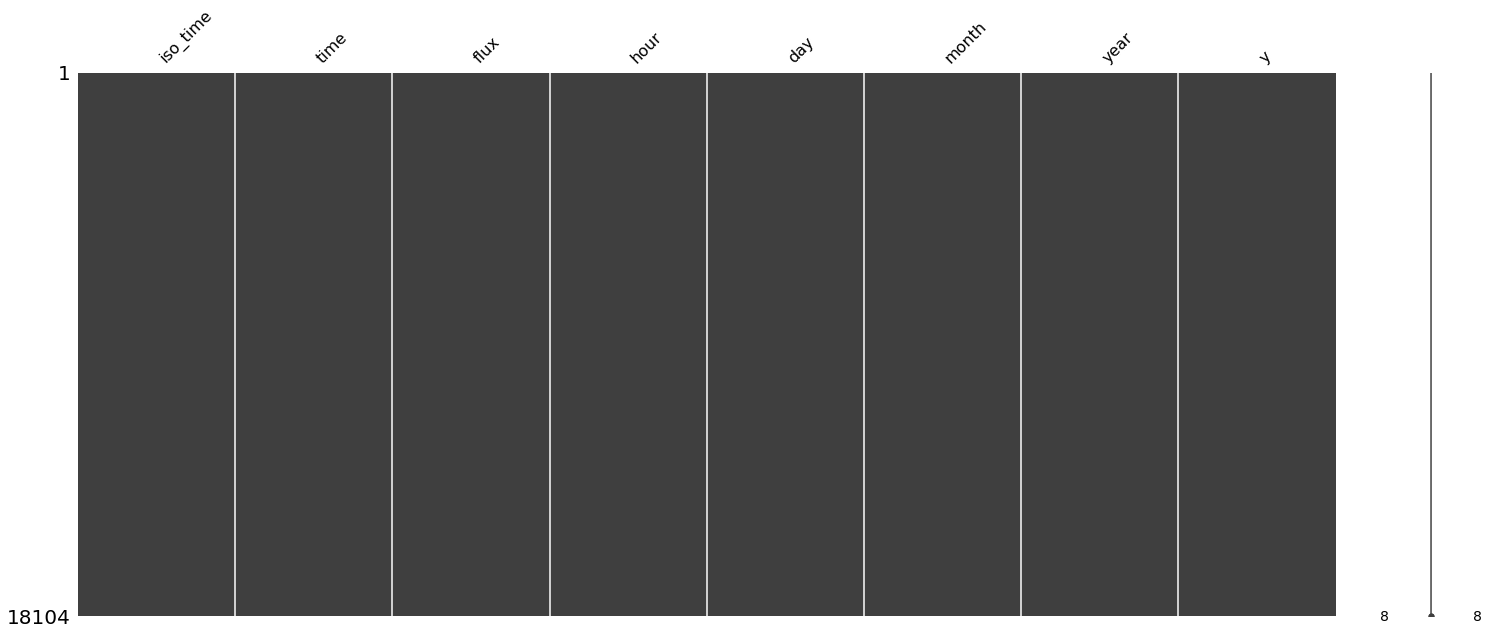

In [37]:
msno.matrix(df)

In [19]:
def create_linear_model(x, y):
    model = linear_model.LinearRegression()
    model.fit(x, y)
    print('Coef:', model.coef_)
    print('Intercept:', model.intercept_)
    print('r2:', r2_score(y, model.predict(x)))
    return model

In [20]:
def create_plus_3_minus_3_features(df, columns='flux'):
    for i in range(1,4):
        t_menos_1 = 'flux_t_{}'.format(i)
        df[t_menos_1] = df[columns].shift(i)
        t_mais_1 = 'flux_tm{}'.format(i)
        df[t_mais_1] = df[columns].shift(-i)

In [21]:
def create_day_features(df, columns='day'):
    for i in range(1,31):
        desc_d = f'd{i}'
        df[desc_d] = df.day.apply(lambda x: 1 if x == i else 0)

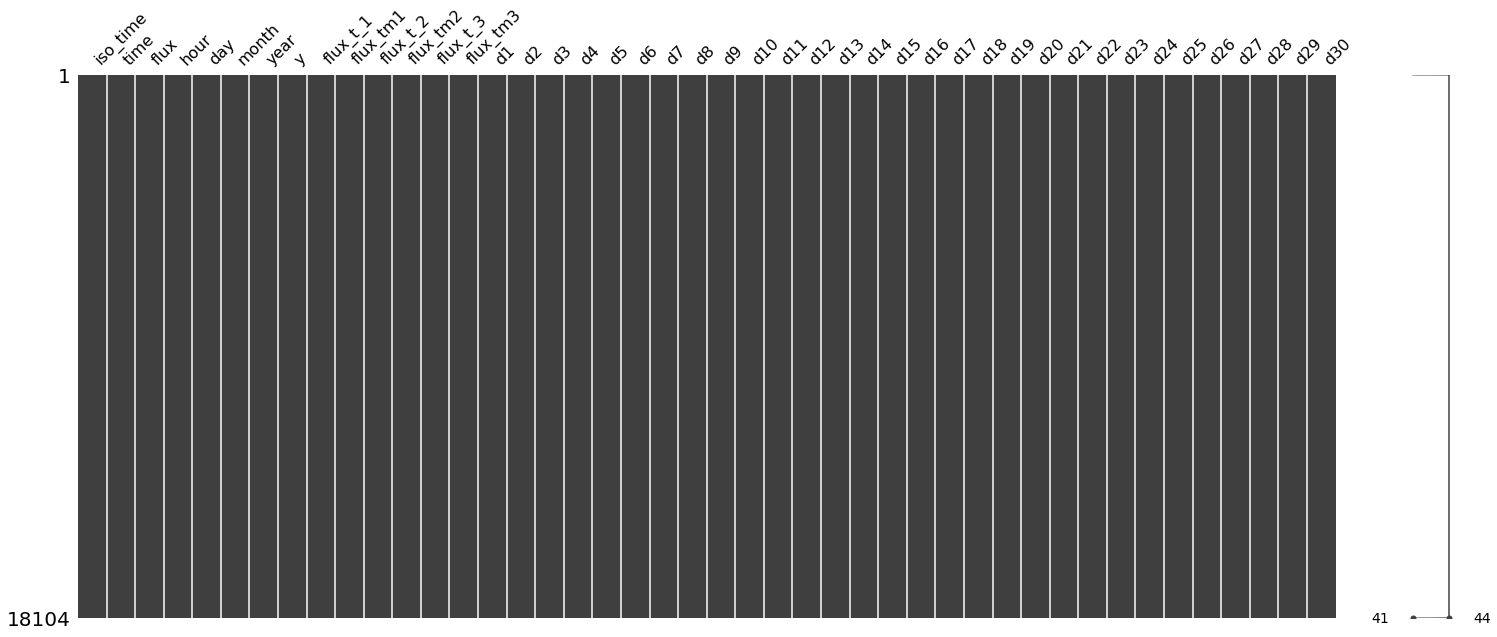

In [39]:
create_plus_3_minus_3_features(df)
create_day_features(df)
msno.matrix(df)

In [23]:
df_clean = df.dropna()
features_col = df_clean.columns[7:]
features_col

Index(['flux_t_1', 'flux_tm1', 'flux_t_2', 'flux_tm2', 'flux_t_3', 'flux_tm3',
       'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11',
       'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21',
       'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30'],
      dtype='object')

In [24]:
x = df_clean[features_col].values
y = df_clean.flux.values.reshape(-1,1)
model_a = create_linear_model(x, y)

Coef: [[-3.36182921e-01 -3.34804552e-01 -5.67538037e-03 -4.81354003e-03
   8.54085705e-02  8.55616544e-02 -5.48960478e+02 -1.23742359e+03
  -1.93301708e+03 -2.57013179e+03 -3.70802209e+03 -4.38216452e+03
  -5.47991308e+03 -6.10044119e+03 -2.26006787e+03 -6.17748727e+03
  -7.27846734e+03 -8.49891911e+03 -8.72313860e+03 -9.80536603e+03
  -1.02165515e+04 -1.10340470e+04 -1.20830857e+04 -1.38078243e+04
  -1.33142239e+04 -1.35581394e+04 -1.47977509e+04 -1.56387007e+04
   2.77555756e-17  8.88178420e-16  2.53893643e+03  2.33686229e+03
   2.12498573e+03  1.85635983e+03  1.33460997e+03  8.71154129e+02]]
Intercept: [2072029.75861424]
r2: 0.896381330030954


In [25]:
import xgboost as xgb

In [26]:
model_xgb = xgb.XGBRegressor()

In [27]:
model_xgb.fit(x,y)

[02:17:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [28]:
r2_score(y, model_xgb.predict(x))

0.8703501015960252